<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/main/notebooks/simple-train-small-case-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improved People Counting with Density Maps
This notebook demonstrates an improved approach for counting people in images by switching from bounding box detection to density map estimation. This method is more effective for counting tasks, especially with a limited dataset.

**Key Improvements:**
1.  **Task Formulation**: Changed from single-object detection to density map regression.
2.  **Data Preprocessing**: A new `Dataset` class generates ground truth density maps from head coordinates provided in JSON files.
3.  **Model Architecture**: Replaced the simple detector with a Fully Convolutional Network (FCN) suitable for producing density maps.
4.  **Loss Function**: Using Mean Squared Error (MSE) between the predicted and ground truth density maps.
5.  **Evaluation**: Implemented Mean Absolute Error (MAE) to measure counting accuracy.

## 1. Setup and Imports

In [11]:
import numpy as np
import cv2
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy.ndimage import gaussian_filter, maximum_filter
from typing import Optional, Tuple, Dict, Any, Union
import warnings

warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Download dataset

In [2]:
!pip install -q kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


#### Session storage

In [ ]:
!kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining

import zipfile
import os

zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

#### Google Drive (recommended)

In [3]:
# @title
import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"
extract_path = "/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset"

# Check if dataset already downloaded
if not os.path.exists(zip_path):
    print("Dataset not found, downloading...")
    !kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining -p /content
else:
    print("Dataset already exists, skipping download.")

# Ensure extract directory exists
os.makedirs(extract_path, exist_ok=True)

# Extract only if not already extracted
if not os.listdir(extract_path):  # Check if folder is empty
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted to:", extract_path)
else:
    print("Dataset already extracted at:", extract_path)


Mounted at /content/drive
Dataset not found, downloading...
 92% 192M/209M [00:00<00:00, 402MB/s]
100% 209M/209M [00:00<00:00, 434MB/s]
Dataset already extracted at: /content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset


## 2. Dataset and Density Map Generation
We define a custom dataset that reads images and their corresponding JSON labels. For each image, it generates a ground truth density map by applying a Gaussian kernel to each annotated head position.

In [6]:
class CrowdCountingDataset(Dataset):
    def __init__(
        self,
        image_dir: str,
        label_dir: str,
        max_samples: int = 50,
        img_size: int = 224,
        downscale_factor: int = 16,
        sigma: float = 4.0,
        transform: Optional[Any] = None,
        return_meta: bool = False,
    ) -> None:
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.downscale_factor = downscale_factor
        self.sigma = sigma
        self.transform = transform
        self.return_meta = return_meta  # whether to return metadata

        all_images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.image_files = all_images[:max_samples]
        self.labels = self._load_labels()

        print(f"Using {len(self.image_files)} images for training.")

    def _load_labels(self) -> Dict[str, Dict[str, Any]]:
        """Load labels from JSON files into a dict."""
        labels = {}
        for img_file in self.image_files:
            label_file = img_file.replace('.jpg', '.json')
            label_path = os.path.join(self.label_dir, label_file)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    data = json.load(f)
                    labels[img_file] = data
        return labels

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(
        self, idx: int
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Dict[str, Any]]:
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # ---- Load and resize image ----
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        image = cv2.resize(image, (self.img_size, self.img_size))
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        # Apply transforms if provided (e.g., augmentations, normalization)
        if self.transform:
            image_tensor = self.transform(image_tensor)

        # ---- Generate density map ----
        output_size = self.img_size // self.downscale_factor
        density_map = np.zeros((output_size, output_size), dtype=np.float32)

        label_data = self.labels.get(img_name)
        if label_data and label_data.get("human_num", 0) > 0:
            raw_points = label_data["points"]

            # Ensure points are extracted correctly
            points = np.array([[p["x"], p["y"]] for p in raw_points], dtype=np.float32)

            for x, y in points:
                scaled_x = (x / orig_w) * output_size
                scaled_y = (y / orig_h) * output_size

                ix, iy = int(scaled_x), int(scaled_y)
                if 0 <= ix < output_size and 0 <= iy < output_size:
                    density_map[iy, ix] += 1.0


        # Smooth with Gaussian filter
        density_map = gaussian_filter(
            density_map, sigma=self.sigma / self.downscale_factor
        )
        density_map_tensor = torch.from_numpy(density_map).unsqueeze(0)  # [1, H, W]

        # Also compute crowd count
        count = float(density_map_tensor.sum())

        if self.return_meta:
            return {
                "image": image_tensor,
                "density": density_map_tensor,
                "count": count,
                "name": img_name,
                "orig_size": (orig_h, orig_w),
            }
        else:
            return image_tensor, density_map_tensor

## 3. Fully Convolutional Network (FCN) for Density Estimation
This FCN model uses a simple CNN backbone to extract features and then a `1x1` convolution to produce a single-channel density map. The output map is 1/16th the size of the input image.

In [7]:
class DensityFCN(nn.Module):
    def __init__(self):
        super(DensityFCN, self).__init__()
        # Backbone: Feature extractor
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 112 -> 56
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 56 -> 28
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 28 -> 14
        )
        # Head: Density map predictor
        self.head = nn.Conv2d(128, 1, 1) # 1x1 conv to produce 1-channel map

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        # Use ReLU to ensure density is non-negative
        return torch.relu(x)

# Initialize model
model = DensityFCN().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Model architecture:")
print(model)

Model parameters: 97,569
Model architecture:
DensityFCN(
  (backbone): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)


## 4. Load Data and Set Up Training

In [9]:
# Define paths (in Colab environment)
BASE_DRIVE_DIR = '/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025'
TRAIN_IMG_DIR = os.path.join(BASE_DRIVE_DIR, 'dataset', 'train', 'images')
TRAIN_LBL_DIR = os.path.join(BASE_DRIVE_DIR, 'dataset', 'train', 'labels')
TEST_IMG_DIR = os.path.join(BASE_DRIVE_DIR, 'dataset', 'test', 'images')

# Create dataset and dataloader
train_dataset = CrowdCountingDataset(
    image_dir=TRAIN_IMG_DIR,
    label_dir=TRAIN_LBL_DIR,
    max_samples=150,
    img_size=224,
    downscale_factor=16
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Loss and Optimizer
criterion = nn.MSELoss() # Pixel-wise MSE for density map regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using 150 images for training.


## 5. Training Loop

Starting training...
Epoch 1/100, Loss: 9.501340
Epoch 20/100, Loss: 6.322829
Epoch 40/100, Loss: 5.773489
Epoch 60/100, Loss: 5.008998
Epoch 80/100, Loss: 5.929259
Epoch 100/100, Loss: 4.119867
Training completed!


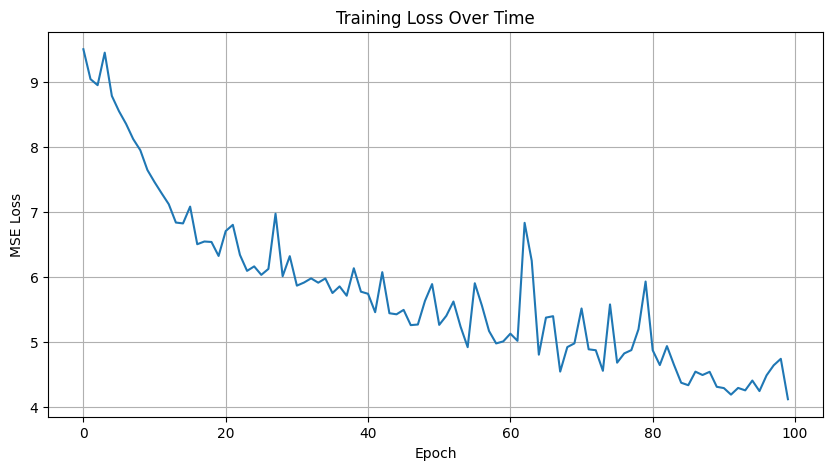

In [10]:
num_epochs = 100 # Increased epochs for better convergence on small dataset
training_losses = []

print("Starting training...")
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, density_maps in train_loader:
        images = images.to(device)
        density_maps = density_maps.to(device)

        # Forward pass
        optimizer.zero_grad()
        pred_density_maps = model(images)

        # Calculate loss
        loss = criterion(pred_density_maps, density_maps)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')

print("Training completed!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

## 6. Evaluation on Test Set
We now evaluate the trained model on the test images. We define a function to predict the count for a single image and then calculate the Mean Absolute Error (MAE) across a sample of the test set.

In [12]:
def predict_count(
    model: torch.nn.Module,
    image_path: str,
    device: torch.device,
    img_size: int = 224
) -> Tuple[np.ndarray, float, np.ndarray]:
    model.eval()

    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (img_size, img_size))
    input_tensor = torch.from_numpy(resized_image).permute(2, 0, 1).float().unsqueeze(0) / 255.0
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        pred_density_map = model(input_tensor)

    # The predicted count is the sum of the density map
    predicted_count = pred_density_map.sum().item()

    return image, predicted_count, pred_density_map.squeeze().cpu().numpy()

def get_ground_truth_count(image_name: str, label_dir: str) -> int:
    label_file = image_name.replace('.jpg', '.json')
    label_path = os.path.join(label_dir, label_file)
    if not os.path.exists(label_path):
        # For test set, we might not have labels. We'll use train labels for MAE calculation.
        return 0
    with open(label_path, 'r') as f:
        data = json.load(f)
    return data['human_num']

def visualize_detections(
    original_image: np.ndarray,
    pred_map: np.ndarray,
    pred_count: float,
    true_count: int,
    img_name: str,
    downscale_factor: int = 16,
    threshold_scale: float = 2.0
) -> None:
    """
    Finds peaks in the density map and draws circles on the original image.
    """
    # Find local maxima in the density map
    footprint = np.ones((3, 3))
    local_max = maximum_filter(pred_map, footprint=footprint) == pred_map

    # Apply a threshold to filter out weak peaks
    threshold = pred_map.mean() * threshold_scale
    peaks = (pred_map > threshold) & local_max

    # Get coordinates of the peaks
    peak_coords = np.argwhere(peaks) # (row, col) format

    # --- Visualization ---
    plt.figure(figsize=(10, 8))

    # Draw circles on the original image
    img_with_circles = original_image.copy()
    orig_h, orig_w = img_with_circles.shape[:2]

    for y_map, x_map in peak_coords:
        # Scale coordinates from map size back to original image size
        x_orig = int((x_map + 0.5) * downscale_factor * (orig_w / 224))
        y_orig = int((y_map + 0.5) * downscale_factor * (orig_h / 224))

        # Draw a red circle
        cv2.circle(img_with_circles, (x_orig, y_orig), radius=15, color=(255, 0, 0), thickness=3)

    plt.imshow(img_with_circles)
    plt.title(f'Detections for: {img_name}\nPredicted Count: {pred_count:.2f} | Ground Truth: {true_count}', fontsize=14)
    plt.axis('off')
    plt.show()

Evaluating model on training images (to check learning)...


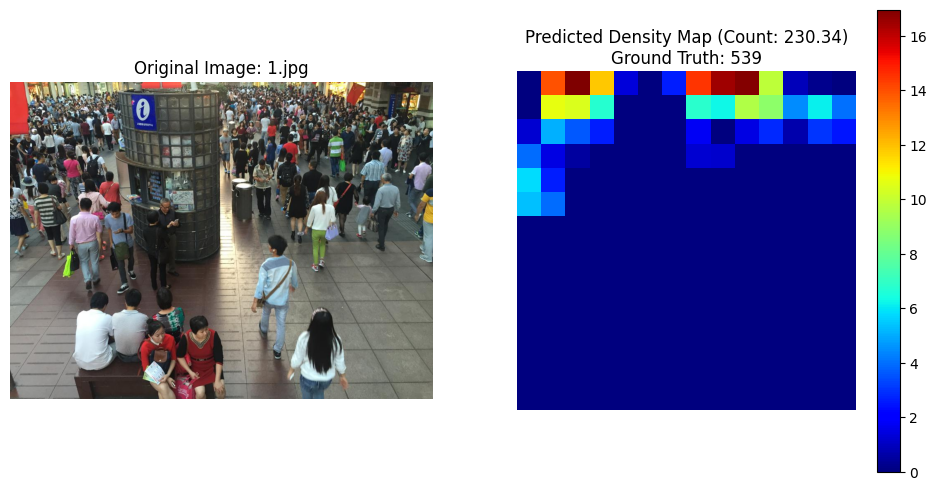

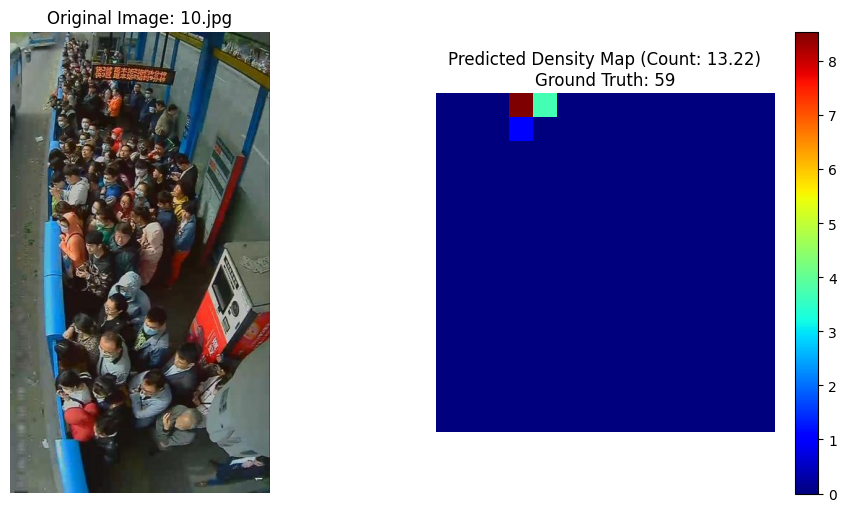

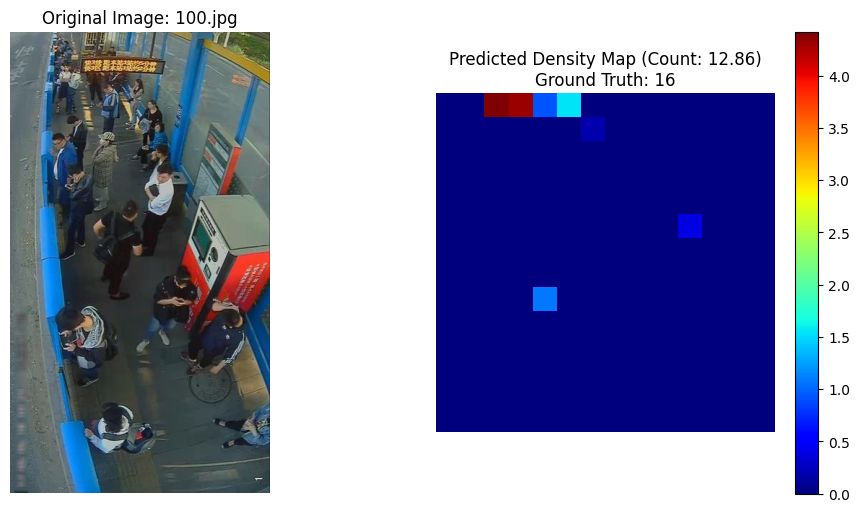


Evaluation Results on Training Sample:
  image_name  true_count  pred_count
0      1.jpg         539  230.340088
1     10.jpg          59   13.217457
2    100.jpg          16   12.859063
3   1000.jpg          30    1.294960
4   1001.jpg         363   89.668205
5   1002.jpg         232  133.509964
6   1003.jpg         206  298.364166
7   1004.jpg         316  858.767639
8   1005.jpg           6    1.827712
9   1006.jpg           6    5.547540

Mean Absolute Error (MAE): 139.7867


In [13]:
print("Evaluating model on training images (to check learning)...")
print("=" * 50)

evaluation_results = []
sample_images_for_eval = train_dataset.image_files[:10] # Use first 10 training images for eval

for img_name in sample_images_for_eval:
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)

    # Get ground truth
    true_count = get_ground_truth_count(img_name, TRAIN_LBL_DIR)

    # Get prediction
    original_image, pred_count, pred_map = predict_count(model, img_path, device)

    evaluation_results.append({
        'image_name': img_name,
        'true_count': true_count,
        'pred_count': pred_count
    })

    # Visualize first 3 images
    if len(evaluation_results) <= 3:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(original_image)
        ax1.set_title(f'Original Image: {img_name}')
        ax1.axis('off')

        im = ax2.imshow(pred_map, cmap='jet')
        ax2.set_title(f'Predicted Density Map (Count: {pred_count:.2f})\nGround Truth: {true_count}')
        ax2.axis('off')
        fig.colorbar(im, ax=ax2)
        plt.show()

# Calculate and display MAE
eval_df = pd.DataFrame(evaluation_results)
mae = (eval_df['pred_count'] - eval_df['true_count']).abs().mean()

print("\nEvaluation Results on Training Sample:")
print(eval_df)
print(f"\nMean Absolute Error (MAE): {mae:.4f}")

## 7. Final Submission Generation
Finally, we run predictions on the actual test set and generate a `submission.csv` file in the required format.

In [14]:
print("Generating submission file for the test set...")

test_images = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.jpg')])
submission_data = []

for img_name in test_images:
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    _, pred_count, _ = predict_count(model, img_path, device)

    submission_data.append({
        'id': img_name,
        'human_num': int(round(pred_count))
    })

submission_df = pd.DataFrame(submission_data)
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
print("\nFirst 5 rows of submission:")
print(submission_df.head())

Generating submission file for the test set...
Submission file 'submission.csv' created successfully.

First 5 rows of submission:
        id  human_num
0    1.jpg          3
1   10.jpg        113
2  100.jpg        180
3  101.jpg          7
4  102.jpg        522
